This tutorial shows how to use [All-Resolutions Inference (ARI)](https://doi.org/10.1016/j.neuroimage.2018.07.060) to identify connected subnetworks that differ between groups in (fMRI) functional connectivity data.

Group-level statistical analyses on fMRI functional connectivity matrices are often performed using the [network-based statistic (NBS)](https://doi.org/10.1016/j.neuroimage.2010.06.041) as an inference method. This approach is actually essentially the same as the cluster-based permutation tests used in M/EEG research, where edges of the connectivity graph are considered neighbors if they share a node. Thus "clusters of neighboring nodes" in cluster-based permutation test language translates to "connected subnetworks" in functional connectivity language.

However, if you've read any of the other <s>rants/</s>documentation/examples associated with this package, you probably know that cluster-based permutation tests, including NBS (as acknowledged by the authors of the NBS [paper](https://doi.org/10.1016/j.neuroimage.2010.06.041)), [overestimate the extent of effects](https://doi.org/10.1111/psyp.13335). In fact, the only claim one can really make about a connected subnetwork identified using NBS is that _at least one_ of the edges in the "subnetwork" is different with respect to your independent variable (but you don't know which edge(s) or how many). While two nodes connected by a single edge _is_ technically a minimal subnetwork, I'm guessing this isn't what most researchers mean when they write about functional subnetworks in their papers. 

Subnetworks identified using ARI, however, come with no such caveats; the edges included in a subnetwork can be taken at face value! And while MNE-ARI wasn't developed with connectivity data in mind, the MNE-like API is flexible enough to allow for any datatype that can be expressed as a numpy array.

In [1]:
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiMapsMasker
from nilearn import plotting
from nilearn import datasets

from scipy.spatial.distance import squareform
import numpy as np

from mne_ari import all_resolutions_inference

Before we get started, we'll load some example functional connectivity data from [Richardson et al. (2018)](https://doi.org/10.1038/s41467-018-03399-2). The dataset contains BOLD timeseries recorded during movie watching, including adults (ages 18-39) and children (ages 3-12). 

In [2]:
# load example dataset
development_dataset = datasets.fetch_development_fmri()
groups = [pheno['Child_Adult'] for pheno in development_dataset.phenotypic]
groups = np.array(groups)

# extract ROI's
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
masker = NiftiMapsMasker(
    msdl_data.maps,
    resampling_target = "data", 
    t_r = 2, 
    detrend = True,
    low_pass = .1, 
    high_pass = .01, 
    memory = 'nilearn_cache', 
    memory_level = 1
).fit()
masked_data = [
    masker.transform(func, confounds) 
    for (func, confounds) 
    in zip(development_dataset.func, development_dataset.confounds)
]

# and compute all-to-all connectivity matrix
conn = ConnectivityMeasure(kind = 'correlation').fit_transform(masked_data)

In [3]:
n_subs = conn.shape[0]
n_rois = conn.shape[1]
conn.shape

(155, 39, 39)

Cool, so we now have connectivity matrices (between 39 ROIs) and their corresponding child/adult labels. But our connectivity matrices contain redundant values (since correlation matrices are symmetric and diagonal values have to be 1), so we'll vectorize the matrices (i.e. taking only the values on one side of the diagonal).

In [4]:
conn = np.stack([squareform(c, checks = False) for c in conn])
conn.shape

(155, 741)

Let's compare connectivity matrices between the two groups using All-Resolutions Inference (ARI).


To start, we'll want to define a notion of adjacency. As in the computation of the popular [network-based statistic](https://doi.org/10.1016/j.neuroimage.2010.06.041) used for comparing group-level functional connectivity data, we'll say two edges are adjacent if they share a node. That way, when we look for "clusters" of edges, we'll in fact be looking for subnetworks of connected components.

The somewhat clunky function below will do what we need, given the number of nodes (ROIs) as input:

In [5]:
def make_edge_adjacency_matrix(n_nodes):
    from itertools import combinations
    from scipy import sparse
    # get squareform node indices for vectorized matrix
    node_idxs = np.array(list(combinations(range(n_nodes), 2)))
    n_edges = node_idxs.shape[0]
    neighb_lists = []
    for e in range(n_edges): # for each edge...
        # find all edges that share a node
        shares_first_node = np.sum(node_idxs == node_idxs[e][0], 1) > 0
        shares_second_node = np.sum(node_idxs == node_idxs[e][1], 1) > 0
        shares_node = np.logical_or(shares_first_node, shares_second_node)
        neighb_lists.append(shares_node) # and call them neighbors
    # combine neighbor lists into 2D adjacency matrix
    adj = np.array(neighb_lists)
    # and sparsify for downstream efficiency / MNE compatibility
    return sparse.csr_matrix(adj)

neighbors = make_edge_adjacency_matrix(n_rois)
neighbors

<741x741 sparse matrix of type '<class 'numpy.bool_'>'
	with 55575 stored elements in Compressed Sparse Row format>

Now, we'll $z$-transform the correlation values (as is commonly done so the data are closer to normally distributed), and then we'll split the connectivity matrices up into their respective child/adult groups to format the data for MNE-ARI.

In [6]:
z = np.arctanh(conn) # Fisher z-transform
conn_adults = z[groups == 'adult']
conn_childs = z[groups == 'child']
X = [conn_adults, conn_childs] # format for ARI

Great, now we have everything we need to find clusters in which the two groups differ with ARI.

In [7]:
p_vals, tdp, clusters = all_resolutions_inference(X, adjacency = neighbors)
n_clusts = len(clusters)
if n_clusts > 0:
    print('We found %d subnetwork that differs between groups!'%n_clusts)

We found 1 subnetwork that differs between groups!


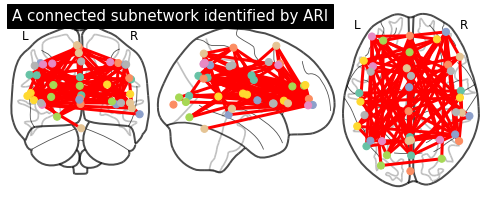

In [8]:
subnet = squareform(clusters[0].astype(int)) # return to matrix form
fig = plotting.plot_connectome(
    subnet, msdl_coords,
    title = 'A connected subnetwork identified by ARI'
)